# Modern Portfolio Theory (MPT)

Modern Portfolio Theory (MPT), developed by economist Harry Markowitz in the 1950s, is a framework for constructing investment portfolios that aim to maximize expected returns for a given level of risk or minimize the level of risk for a given expected return. 
MPT revolutionized the way investors think about diversification and risk management. 
Modern Portfolio Theory has had a profound impact on investment strategy and asset allocation, providing a systematic approach to balancing risk and return in investment portfolios. 

In this notebook we will be implementing the portfolio optimization from scratch and then use some packages to automate it. Later we will also look at different volatility calculations and how it affects the results.

In [98]:
import yfinance as yf
import pandas_datareader.data as pdr
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

yf.pdr_override()

# Define a list of stock symbols
stock_symbols = ['AAPL', 'TSLA', 'JPM', 'GS']

# start date
start_date = '2018-01-01'
# end date
end_date = '2021-01-01'

# Fetch stock data along with sector information
portfolio = pdr.get_data_yahoo(stock_symbols,start_date,end_date)['Close']

# portfolio returns
portfolio_returns = portfolio.pct_change()

# Generate random weights for each asset we have to optimize this
weights = np.random.rand(len(stock_symbols))
weights /= weights.sum()  # Normalize weights to ensure they sum up to 1


[*********************100%%**********************]  4 of 4 completed


Portfolio variance is defined as:

$\sigma_{port}^2 = weights^{T} \cdot Cov_{port} \cdot weights$

where $Cov_{port}$ is the covariance matrix of the portfolio and $weights$ is the vector of weights for each asset. 

In [47]:
# variance matrix 
var_yr = portfolio_returns.cov() * 252

print(var_yr.shape,weights.T.shape,np.transpose(weights).shape)
# portfolio variance
port_var = weights.T@var_yr@weights

# portfolio volatility
port_vol = np.sqrt(port_var)

print(port_var, port_vol)

(10, 10) (10,) (10,)
0.10169861101583214 0.3189021966306161


In Modern Portfolio Theory (MPT), the goal is typically to either maximize the expected portfolio return for a given level of risk or minimize the portfolio risk for a given level of expected return. The optimization problem involves finding the weights of each asset in the portfolio that achieve these objectives. Here are the general formulas for the optimization problems in MPT:

<u>Maximizing Expected Portfolio Return for a Given Level of Risk</u>:

Objective:
$ \text{Maximize} \quad \text{Expected Portfolio Return} = \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i $

Subject to:
$ \sum_{i=1}^{n} w_i = 1 $
$ \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} \leq \text{Target Risk} $

Where:
- $ n $ is the number of assets in the portfolio.
- $ w_i $ is the weight of asset $ i $ in the portfolio.
- $ \text{Expected Return}_i $ is the expected return of asset $ i $.
- $ \text{Covariance}_{ij} $ is the covariance between the returns of assets $ i $ and $ j $.
- The constraint $ \sum_{i=1}^{n} w_i = 1 $ ensures that the weights sum up to 1.

<u>Minimizing Portfolio Risk for a Given Level of Expected Return</u>:

Objective:
$ \text{Minimize} \quad \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} $

Subject to:
$ \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i \geq \text{Target Expected Return} $
$ \sum_{i=1}^{n} w_i = 1 $

Where:
- $ \text{Target Expected Return} $ is the desired level of expected return for the portfolio.

These optimization problems are typically solved using mathematical optimization techniques. The solutions will give you the set of portfolio weights that achieve the specified objectives.

In [108]:
# Efficient frontier
import pandas as pd 

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Calculate the annulaized portfolio return
    returns = np.dot(mean_returns, weights) * 252

    # Calculate the annulaized portfolio volatility
    stdv = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return stdv, returns


def random_port_gen(nsim, expected_returns, covariance_matrix, risk_free_rate):
    # Initialize array to store results, where each column represents a portfolio
    p_results = np.zeros((3, nsim))
    # List to store the weights of each equity in each portfolio
    p_weights = []

    for i in range(nsim):
        # Generate random weights for each equity
        weights = np.random.random(len(expected_returns))
        # Normalize the weights to sum to 1
        weights /= np.sum(weights)
        # Add the weights to the portfolio weight list
        p_weights.append(weights)

        # Calculate portfolio standard deviation and return
        p_std_dev, p_return = portfolio_annualized_performance(weights, expected_returns, covariance_matrix)

        # Store the results
        p_results[0, i] = p_std_dev
        p_results[1, i] = p_return

        # Calculate and store the Sharpe ratio
        p_results[2, i] = (p_return - risk_free_rate) / p_std_dev

    result_df = pd.DataFrame(p_results.T, columns=['std_dev', 'return', 'sharpe'])

    return result_df, p_weights


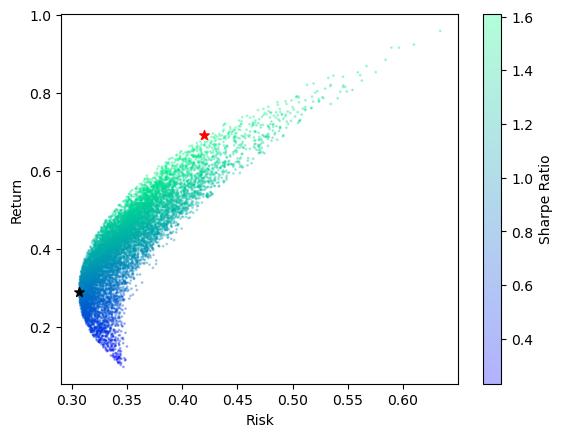

In [127]:

mean_returns = portfolio_returns.mean()
cov_matrix = portfolio_returns.cov()
# Number of portfolios to simulate
nsim = 10000
# Risk free rate 
risk_free_rate = 0.018

# run the simulation
results, weights = random_port_gen(nsim,mean_returns, cov_matrix, risk_free_rate)
# get max Sharpe ratio index
max_sharpe_idx = np.argmax(results['sharpe'].values)

# get minimum volatility
min_vol_idx = np.argmin(results['std_dev'].values)

# get std_dev and returns at max Sharpe ratio
stdev_maxsharpe, returns_maxsharpe = results['std_dev'].iloc[max_sharpe_idx], results['return'].iloc[max_sharpe_idx]


# get std_dev and returns at minimum volatility
stdev_minvol, returns_minvol = results['std_dev'].iloc[min_vol_idx], results['return'].iloc[min_vol_idx]


# pull the allocation associated with max Sharpe ratio
max_sharpe_allocation =  pd.DataFrame(weights[max_sharpe_idx],index=portfolio.columns,columns=['allocation'])
# round off
max_sharpe_allocation['allocation'] = [round(i*100,2) for i in max_sharpe_allocation['allocation']]


# pull the allocation associated with max Sharpe ratio
min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=portfolio.columns,columns=['allocation'])
# round off
min_vol_allocation['allocation'] = [round(i*100,2) for i in min_vol_allocation['allocation']]



# Plot the efficient frontier
fig,ax = plt.subplots(1,1)
cb = ax.scatter(results['std_dev'],results['return'],c=results['sharpe'], cmap='winter', marker='o', s=1, alpha=0.3)

# plot max Sharpe ratio
ax.scatter(stdev_maxsharpe, returns_maxsharpe, marker='*', color='r', s=50)

# plot min volatility
ax.scatter(stdev_minvol, returns_minvol, marker='*', color='k', s=50)

ax.set_xlabel(r'Risk')
ax.set_ylabel(r'Return')
ax.plot()

cbar = fig.colorbar(cb)
cbar.set_label('Sharpe Ratio')

plt.show()

In [129]:
print("At maximum Sharpe Ratio\n")
print(f"Return:{returns_maxsharpe}")
print(f"Volatility: {stdev_maxsharpe}")
print(f"Portfolio: {max_sharpe_allocation}")
print("\n")
print("At Minimum risk\n")
print(f"Return:{returns_minvol}")
print(f"Volatility: {stdev_minvol}")
print(f"Portfolio: {min_vol_allocation}")
print("\n")

At maximum Sharpe Ratio

Return:0.6930464332440198
Volatility: 0.41934156932347666
Portfolio:       allocation
AAPL       53.23
GS          0.23
JPM         2.30
TSLA       44.24


At Minimum risk

Return:0.2916941941910505
Volatility: 0.30696348715945215
Portfolio:       allocation
AAPL       49.74
GS          2.71
JPM        45.80
TSLA        1.75


